# RDS Lab 11: Explaining models with SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. SHAP values interpret the impact of a particular value for a given feature on the prediction, relative to a baseline value of that feature.

You can find the original paper about the SHAP package [here](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf).

SHAP values break down a prediction to show the impact of each feature. Where could you use this?

* A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
* A healthcare provider wants to identify what factors are driving a patient's risk of some disease so they can directly address those risk factors with targeted health interventions (Source: [Kaggle](https://www.kaggle.com/dansbecker/shap-values))



This lab is based on Scott Lundberg's [SHAP Demo](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html). We'll be explaining a sentiment analysis model using SHAP.


In [ ]:
# Required installations
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the required modules
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
shap.initjs()

## Step 1: Load the IMDB dataset and extract features

The dataset we use is the classic IMDB dataset from [this paper](https://www.aclweb.org/anthology/P11-1015/). It consists of movie reviews, and our task is to predict whether the review is positive or negative. 

In [ ]:
# Load the data
corpus, y = shap.datasets.imdb()

# Take a look at the first example and its corresponding class (True if review is positive)
print('Class:', y[0])
corpus[0]

Class: False


"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

Note that this data is just text. We must preprocess and extract numerical features from the data before feeding it into a classification model. 

In [ ]:
# Split into train and test sets
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

The most intuitive way to transform text into numbers would be to simply count how many times each word occurs in each text. We could represent each document as a vector of word counts, where each element of the vector corresponds to one word in our vocabulary.

For example, consider a corpus of the following documents:
- "The rat ate the pizza."
- "The pizza is delicious."
- "The cats are fluffy."

We have 9 words in the vocabulary: ['ate', 'are', 'cats', 'delicious', 'fluffy', 'is', 'pizza', 'rat', 'the']. We could represent the _first_ document as [1, 0, 0, 0, 0, 0, 1, 1, 2]. 



However, this method has some shortcomings. 
#### **TODO 1: Can you think of any?**

Instead, we're going to use the [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from sklearn. TF-IDF stands for "term frequency - inverse document frequency." In its simplest form, for each word (term) $i$ in each document $j$, we calculate the TF-IDF value $w_{i,j}$ as:

<img src="https://miro.medium.com/max/638/1*Uucq42G4ntPGJKzI84b3aA.png" />

We represent each document as a vector of the TF-IDF values for each word. Using the example above, the first document would be represented as [0.47, 0, 0, 0, 0, 0, 0.17, 0.47, 0].

The TF–IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Here, the TfidfVectorizor will make this transformation for us. **Think about what we are "fitting" on the training data in the code below.**

In [ ]:
# Fit vectorizer on training data, then transform both the training and test data
vectorizer = TfidfVectorizer(min_df=10) # Ignore words that appear in < 10 reviews
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

## Step 2: Fit a logistic regression model on the data

In [ ]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [ ]:
# Evaluate our classifier's performance
sklearn.metrics.accuracy_score(model.predict(X_test), y_test)

0.8476

In [ ]:
# For a baseline, about 50% of the test data is positive reviews
# Our model is pulling out meaningful structure!
np.mean(y_test)

0.5148

## Step 3: Explain the model using SHAP

We need to create an **explainer** object in SHAP. The type of SHAP explainer we use will be determined by the sort of model that we trained. Because we trained logistic regression model, which is from sklearn.linear_model, we'll want to use a LinearExplainer. See other options [here](https://shap.readthedocs.io/en/latest/#). 

---

SHAP has two different ways to interpret the meaning of changing an input to the black box algorithm. Suppose SHAP changes the frequency of the word "cinematography", ran our model, and saw the prediction change. We could interpret this as either:
1. **Stay true to the model:** if the model depends on one inut ["cinematography"], then only that word gets credit for the model's behavior.
1. **Stay true to the data:** "if the model depends on one input ["cinematography"] but that input is correlated with another input ["good"], then both get some credit for the model’s behavior".

This is a judgement call and is subjective. Today, we will take the first approach, called the `interventional` approach by SHAP.

In [ ]:
# Initialize the explainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


### Summary Plot

We can use `summary_plot` to summarize the most important features. **What are we looking at in this graph?**
- Each dot is an example in the test set
- The color of each dot tells us about the magnitude of the feature -- that is, the magnitude of the TF-IDF value for that word in that document (low to high)
- The SHAP value tells us the contribution of that feature to each prediction

Based on this information, 
- What order are these words in? What determines which words we're seeing in this visualization? [[answer](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html#Feature-ordering)]
- Why are the dots for the token "and" so tightly clustered?
The token “great” has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


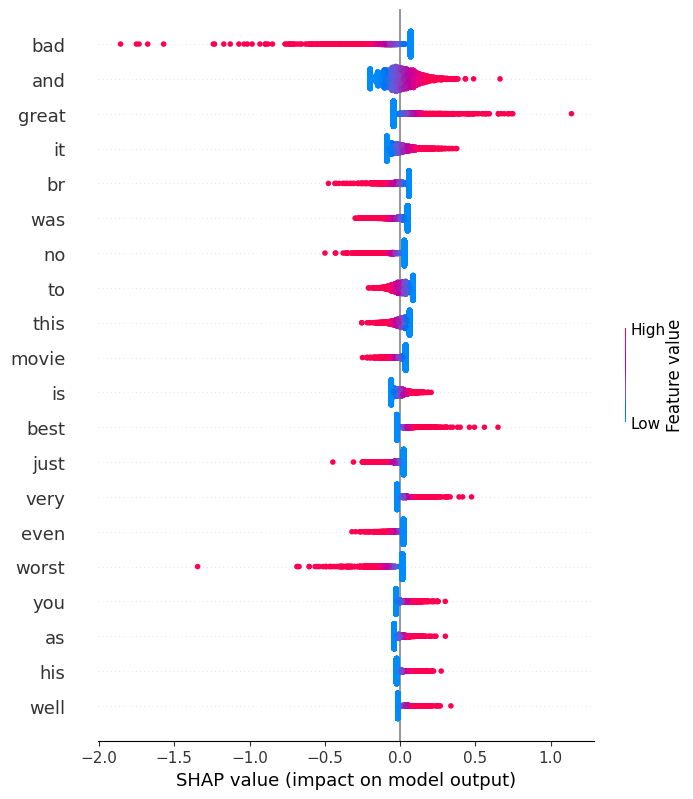

In [ ]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

### Dependence Plots

Dependence plots let us zoom in on a single feature and see how its 1) importance and 2) relationship to the outcome vary across its range.


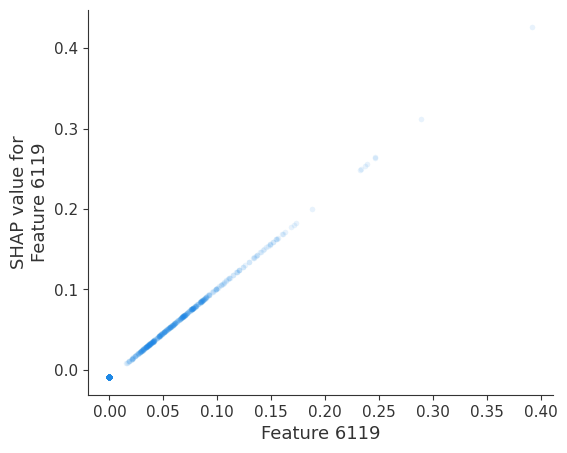

In [ ]:
# How important is the tf-idf for the word "fun"?
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("fun"), 
                     shap_values, X_test_array, alpha=0.1, interaction_index=None)

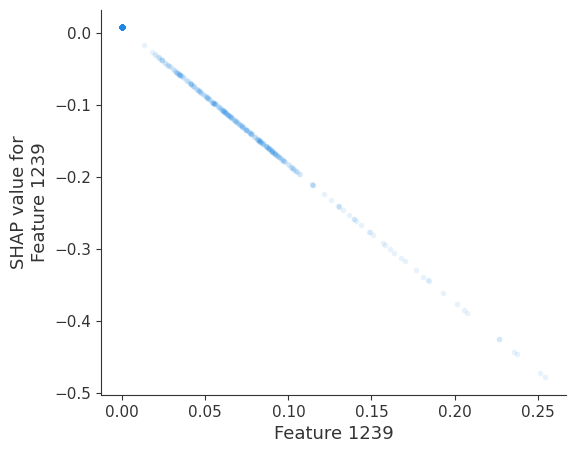

In [ ]:
# How important is the tf-idf for the word "awful"?
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("awful"), 
                     shap_values, X_test_array, alpha=0.1, interaction_index=None)

We can also color the plot by the relationship between two features. For example, we might expect the word "enjoyable" to have a lower SHAP value in texts where we also see the word "not"...

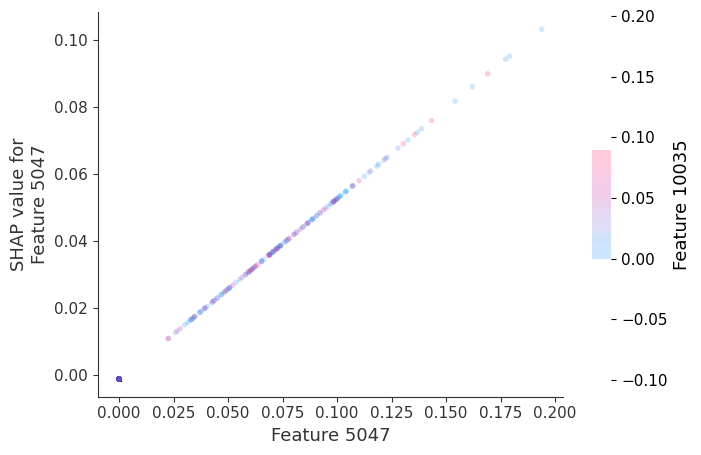

In [ ]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("enjoyable"), shap_values, X_test_array, alpha=0.2, 
                     interaction_index=vectorizer.get_feature_names_out().tolist().index("not"))

...but this turns out not to be the case because we're using a linear model.

These plots aren't super useful for this particular application, but they *are* important for cases where we suspect a nonliner relationship between a feature and the outcome. See the results for age in the adult dataset [here](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html).

## Prediction Decomposition

Next, let's look at the explanation for a single review. Here, we decompose a prediction with the following equation:

> sum(SHAP values for all features) = pred_for_review - pred_for_baseline_values

The SHAP values of all features sum up to explain why the prediction was different from the baseline.

In [ ]:
shap.initjs()
idx = 1
print("Positive" if y_test[idx] else "Negative", "Review:")
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Negative Review:
I don't understand the positive comments made about this film. It is cheap and nasty on all levels and I cannot understand how it ever got made.<br /><br />Cartoon characters abound - Sue's foul-mouthed, alcoholic, layabout, Irish father being a prime example. None of the characters are remotely sympathetic - except, briefly, for Sue's Asian boyfriend but even he then turns out to be capable of domestic violence! As desperately unattractive as they both are, I've no idea why either Rita and/or Sue would throw themselves at a consummate creep like Bob - but given that they do, why should I be expected to care what happens to them? So many reviews keep carping on about how "realistic" it is. If that is true, it is a sad reflection on society but no reason to put it on film.<br /><br />I didn't like the film at all.



We predicted 0.07, whereas the base_value is -0.1842. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. In this example, the biggest impacts come from "liked" which are strongly positive.

Next, let's identify the features that contribute to the positive and negative classification of a document:

In [ ]:
# Checking the words that contribute to the positive and negative classification of document 7
idx = 8
vals = shap_values[idx,:]
positive_sentiment_weight = defaultdict(float)
negative_sentiment_weight = defaultdict(float)
feats = vectorizer.get_feature_names_out()

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_sentiment_weight[feat_i] += val_i
  elif val_i < 0:
    negative_sentiment_weight[feat_i] += val_i

In [ ]:
list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[:10]

[('liked', 0.08674314550261075),
 ('her', 0.07134152349374982),
 ('bad', 0.07051523697015553),
 ('life', 0.06952383596327918),
 ('great', 0.06507276603302455),
 ('performance', 0.06394317111719076),
 ('this', 0.06327791968951758),
 ('it', 0.04578675145348898),
 ('strong', 0.0366521301746679),
 ('well', 0.03399927607783928)]

In [ ]:
list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1)))[:10]

[('boring', -0.08722351199220499),
 ('dull', -0.06901265725532861),
 ('and', -0.06348277948468582),
 ('br', -0.06135798303617854),
 ('badly', -0.05652792748001576),
 ('only', -0.054473529409197224),
 ('why', -0.03784129089114577),
 ('that', -0.03772100799381657),
 ('no', -0.03580117995304831),
 ('tries', -0.03366438205009429)]

# TODO: **Select another review and explain the prediction:**

In [ ]:
# Your code here